<a href="https://colab.research.google.com/github/uteyechea/crime-prediction-using-artificial-intelligence/blob/master/Part2_Spatial_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part 2: Classify the spatial distribution of crime data
We will use k-means to classify the spatial distribution of crimes, i.e. we will form clusters that divide the city of Chicago in zones, where each cluster will be a zone. The number of clusters depends on the processing power of your machine. In our case we will only consider 20 clusters, it would be better to consider smaller zone areas. 

##2.1 Dependencies, mount Google Drive and set system path
Import the relevant packages we will use to preprocess the raw data files.

In [1]:
import os
import gc

import pandas as pd
from sklearn.cluster import KMeans
import matplotlib. pyplot as plt
from collections import defaultdict

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path='/content/drive/My Drive/Colab Notebooks/crime_prediction'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##2.2 Load crime data file to memory 
We will parse the datetime column in file as python's datetime type, then we will set the smallest time unit to be one day. Further work: working with minutes as the smallest unit of time. 

In [2]:
file_path=os.path.join(path,'data','CLEAR.csv')
file=pd.read_csv(file_path,sep=',',parse_dates=['Date']) #Parse datetime column as python's datetime type.
file['Date']=pd.to_datetime(file['Date'].dt.strftime('%Y-%m-%d')) #Set the smallest unit of time to be days.
print(file.head())

        Date                Primary Type  ...   Latitude  Longitude
0 2001-01-01                       THEFT  ...  41.764002 -87.656290
1 2001-01-01                       THEFT  ...  41.862175 -87.711496
2 2001-01-01  OFFENSE INVOLVING CHILDREN  ...  41.804197 -87.626096
3 2001-01-01                       THEFT  ...  41.812451 -87.694479
4 2001-01-01                       THEFT  ...  41.963238 -87.778194

[5 rows x 8 columns]


In [4]:
file

,Date,Primary Type,Description,Location Description,Arrest,Domestic,Latitude,Longitude
0,2001-01-01,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,41.764002,-87.656290
1,2001-01-01,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,41.862175,-87.711496
2,2001-01-01,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,APARTMENT,False,False,41.804197,-87.626096
3,2001-01-01,THEFT,FINANCIAL ID THEFT:$300 &UNDER,RESIDENCE,False,False,41.812451,-87.694479
4,2001-01-01,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,41.963238,-87.778194
...,...,...,...,...,...,...,...,...
6472799,2020-07-08,THEFT,RETAIL THEFT,GROCERY FOOD STORE,False,False,41.954344,-87.664922
6472800,2020-07-08,THEFT,OVER $500,RESIDENCE,False,False,41.754333,-87.613790
6472801,2020-07-08,ROBBERY,AGGRAVATED,STREET,False,False,41.795364,-87.599238
6472802,2020-07-08,DECEPTIVE PRACTICE,COMPUTER FRAUD,CONVENIENCE STORE,False,False,41.953853,-87.713208


##2.3 Create list of available locations to classify into zones

All crimes happened at some longitude, latitude, we will use this pair of data points to classify the spatial distribution in the city of Chicago. Segmentating the city into N zones. 

In [5]:
location={
    'Longitude': file.loc[:,'Longitude'],
    'Latitude': file.loc[:,'Latitude']
         }
location=pd.DataFrame(location)         
print(location.head())

   Longitude   Latitude
0 -87.656290  41.764002
1 -87.711496  41.862175
2 -87.626096  41.804197
3 -87.694479  41.812451
4 -87.778194  41.963238


##2.4 K-means algorithm
From the SciKit-Learn library select a classification algorithm, then select and appropiate number of clusters, appropiate according to the computational resources of your machine.

In [6]:
#Fit the data.
kmeans = KMeans(n_clusters=20)
kmeans.fit(location)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [7]:
#Learn the labels.
labels = kmeans.predict(location)
centroids = kmeans.cluster_centers_

Insert into crime data a new column for the zone

In [8]:
file['Zone']=list(labels) #Insert new dictinary key zone, where longitude,latitude map to zone using k-means
print(file.head())

        Date                Primary Type  ...  Longitude Zone
0 2001-01-01                       THEFT  ... -87.656290   15
1 2001-01-01                       THEFT  ... -87.711496    0
2 2001-01-01  OFFENSE INVOLVING CHILDREN  ... -87.626096   11
3 2001-01-01                       THEFT  ... -87.694479    8
4 2001-01-01                       THEFT  ... -87.778194    2

[5 rows x 9 columns]


##2.5 Select a crime type to forecast
We will select one out of the n available crime types to train our RNN. Further work: To increase performance we will try to simultaneously train the RNN for all crime types, i.e. multiple time series training simultaneously. I don't know how to do it yet.

In [9]:
#Theft has been selected because it has many data points.
theft={}
theft['Date']=file[file['Primary Type']=='THEFT'].loc[:,'Date'] #Extract date from all crimes data file.

#Extract zone(N) from all crimes data file.
zones=set(labels) #Create a mathematical set of labels, labels refers to zone numbers, i.e. zone 1, zone 2, etc
for element in zones:
  if element>=2:
    theft['zone'+str(element)]=file[file['Zone']== element ].loc[:,'Zone']/element
  else:
    theft['zone'+str(element)]=file[file['Zone']== element ].loc[:,'Zone']

In [10]:
#Group all thefts per day
theft=pd.DataFrame(theft)
theft=theft.groupby(['Date']).sum()
theft #shoe me how it looks

,zone0,zone1,zone2,zone3,zone4,zone5,zone6,zone7,zone8,zone9,zone10,zone11,zone12,zone13,zone14,zone15,zone16,zone17,zone18,zone19
Date,,,,,,,,,,,,,,,,,,,,
2001-01-01,0.0,6.0,12.0,3.0,6.0,0.0,10.0,11.0,10.0,6.0,2.0,7.0,6.0,6.0,0.0,10.0,3.0,3.0,14.0,13.0
2001-01-02,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2001-01-03,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2001-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2001-01-06,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-04,0.0,4.0,0.0,3.0,3.0,0.0,2.0,14.0,3.0,8.0,0.0,5.0,3.0,9.0,1.0,4.0,3.0,6.0,10.0,8.0
2020-07-05,0.0,9.0,2.0,3.0,7.0,0.0,6.0,13.0,5.0,6.0,1.0,8.0,1.0,2.0,1.0,2.0,0.0,5.0,1.0,3.0
2020-07-06,0.0,12.0,6.0,6.0,5.0,0.0,4.0,13.0,4.0,11.0,1.0,10.0,2.0,3.0,0.0,5.0,1.0,11.0,11.0,5.0


##2.6 Nomalize data

From sklearn we will select an appropiate normalization algorithm, there are many types of algorithms so consider your choice carefully.

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() #selected algorithm. Maps to [0,1]. Very sensitive to outliers.
theft_np=theft.to_numpy() #sklearn uses np arrays.
scaler.fit(theft_np) #Esimate algorithm parameters.
theft_tmp=scaler.transform(theft_np) #Apply algorithm to data, i.e. map all values to normalized values.
theft_tmp=pd.DataFrame(theft_tmp) #Revert from np array to pandas dataframe.
#we lost some information during the conversion to a np array, so we are getting it back.
theft_tmp.columns=theft.columns 
theft=theft_tmp.set_index(theft.index)

In [12]:
theft=theft.dropna(axis='columns') #remove NANs in case something went wrong while applying the normalization

In [13]:
theft

,zone0,zone1,zone2,zone3,zone4,zone5,zone6,zone7,zone8,zone9,zone10,zone11,zone12,zone13,zone14,zone15,zone16,zone17,zone18,zone19
Date,,,,,,,,,,,,,,,,,,,,
2001-01-01,0.0,0.171429,0.37500,0.100000,0.193548,0.0,0.454545,0.075342,0.40,0.12,0.181818,0.205882,0.206897,0.171429,0.000000,0.294118,0.166667,0.09375,0.304348,0.342105
2001-01-02,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.045455,0.006849,0.00,0.00,0.000000,0.000000,0.034483,0.000000,0.000000,0.029412,0.055556,0.00000,0.021739,0.000000
2001-01-03,0.0,0.000000,0.03125,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2001-01-05,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.021739,0.000000
2001-01-06,0.0,0.000000,0.00000,0.000000,0.032258,0.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-04,0.0,0.114286,0.00000,0.100000,0.096774,0.0,0.090909,0.095890,0.12,0.16,0.000000,0.147059,0.103448,0.257143,0.038462,0.117647,0.166667,0.18750,0.217391,0.210526
2020-07-05,0.0,0.257143,0.06250,0.100000,0.225806,0.0,0.272727,0.089041,0.20,0.12,0.090909,0.235294,0.034483,0.057143,0.038462,0.058824,0.000000,0.15625,0.021739,0.078947
2020-07-06,0.0,0.342857,0.18750,0.200000,0.161290,0.0,0.181818,0.089041,0.16,0.22,0.090909,0.294118,0.068966,0.085714,0.000000,0.147059,0.055556,0.34375,0.239130,0.131579


##2.7 Save crime of type N to file crime_type.csv

In [14]:
file_path = os.path.join(path,'data','theft.csv')
theft.to_csv(file_path,index=True)

##2.8 Make a plot of the classified zones.
Using plotly. Choose colors, can i choose them automatically?
then scatter plot all location points if there are enough points you will shape the city.

In [15]:
#Plotly color map for all different labels. Only works for up to 20 labels.
colmap={1:'k',2:'g',3:'b',4:'c',5:'m',6:'y',7:'r',\
        8:'chartreuse',9:'gold',10:'darkkhaki',\
        11:'olivedrab',12:'royalblue',13:'lightseagreen',\
        14:'darkorchid',15:'plum',16:'palevioletred',\
        17:'crimson',18:'tomato',19:'darkorange',\
        20:'orangered'
        }

(-88.0, -87.4)

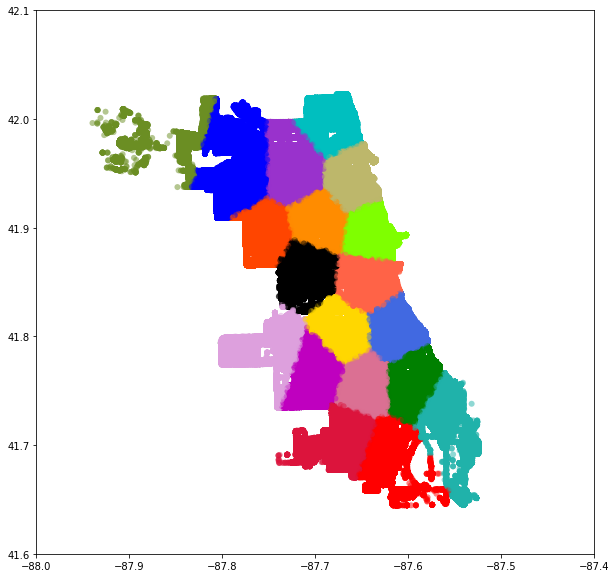

In [24]:
fig = plt.figure(figsize=(10, 10))
colors = list(map(lambda x: colmap[x+1], labels))

plt.scatter(location['Longitude'], location['Latitude'], color=colors, alpha=0.5, edgecolor='none')

for idx, centroid in enumerate(centroids):
    plt.scatter(*centroid, color=colmap[idx+1])

#Chicago city limits
plt.ylim(41.6, 42.1) 
plt.xlim(-88, -87.4)
#plt.show()#not needed while in a jupyter notebook.